## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Минимальное требование к качеству модели - значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

### Основные задачи проекта.
В настоящей работе будут исследованы модели линейной регрессии, случайного леса и градиентного бустинга. Очевидной целью будет выбор наилучших гиперпараметров в используемых реализациях алгоритмов и сравнение качества лучших моделей на тестовой выборке. 

Кроме того, одна из основных задач данной работы - это исследование влияния набора рукотворных обучающих признаков на качество модели и выбор наиболее оптимальных обучающих признаков.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import time

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
data.index.is_monotonic

True

In [6]:
(31+30+31+30+31+31) * 24 * 6

26496

In [7]:
data.index.has_duplicates

False

# 1. Выводы.
- Всего предоставлено 26496 данных о суммарном кол-ве заказов за каждые 10 мин, период - 6 месяцев.
- Данные последовательные, пропусков нет.

# 2. Анализ.

## 2.1. Тренды и сезонность, статистики.

In [8]:
def show_seasonal_decompose(data, timeframe='1H'):
    data = data.resample(timeframe).sum()
    decomposed = seasonal_decompose(data)
    fig, (ax1, ax2,  ax3) = plt.subplots(3,1, figsize=(12, 9), constrained_layout=True)
    fig.suptitle(f'This is seasonal decompose for timeframe {timeframe}', fontsize=16)
    decomposed.trend.plot(ax=ax1, title='Trend')
    decomposed.seasonal.plot(ax=ax2, title='Seasonality')
    plt.title('Seasonality')
    decomposed.resid.plot(ax=ax3, title='Residuals')
    plt.title('Residuals')

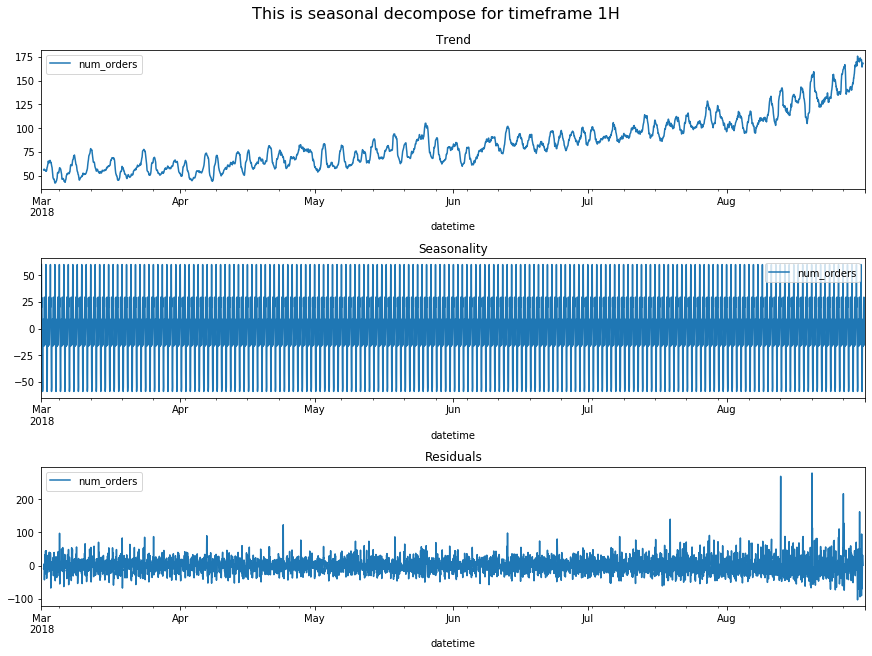

In [9]:
show_seasonal_decompose(data, '1H')

Данные с часовым усреднением демонстрируют суточные циклы активности 

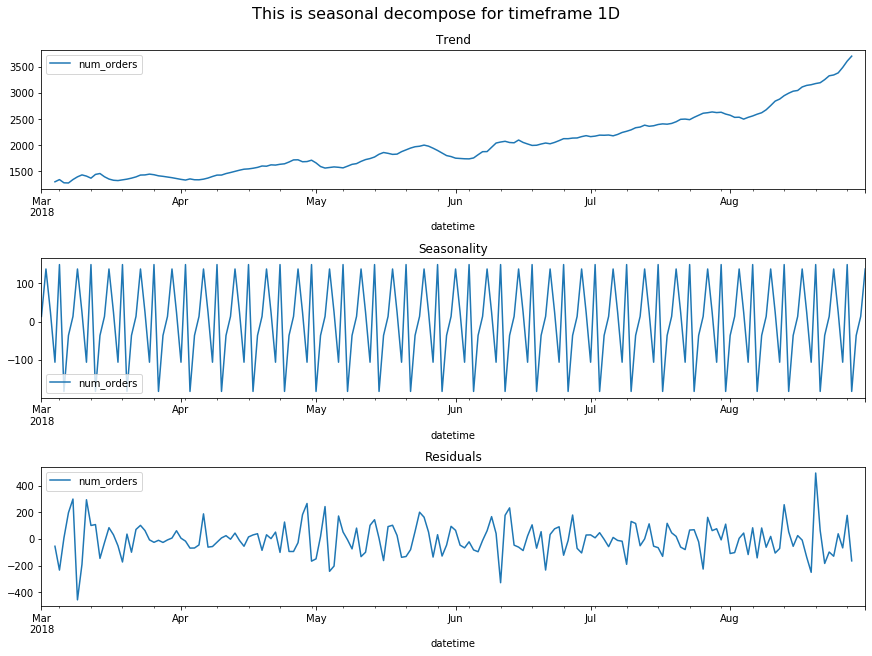

In [10]:
show_seasonal_decompose(data, '1D')

Данные с суточным усреднением демонстрируют недельный цикл и отчетливо фиксируют тренд планомерного роста заказов в течение всего срока, за который были предоставлены данные.

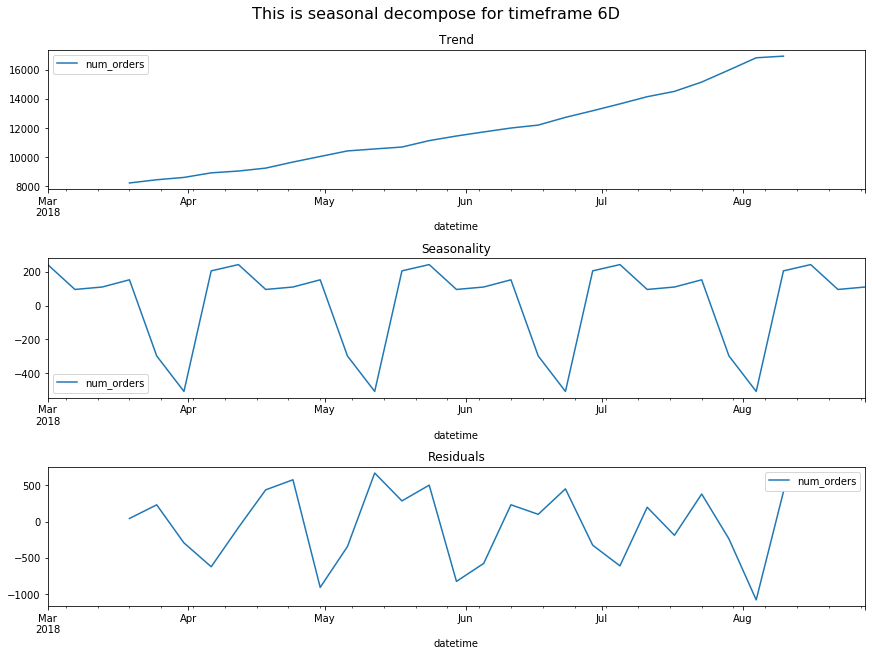

In [83]:
show_seasonal_decompose(data, '6D')

Усреднение за максимально возможное кол-во дней отчетливо продемонстрировало линейный тренд удвоения заказов за весь срок, по которому есть данные

In [84]:
# модель будет предсказывать кол-во заказов на следующий час, ресемплируем ряд
data_1hour = data.resample('1H').sum()

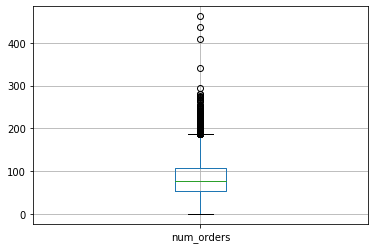

In [85]:
a = data_1hour.boxplot()

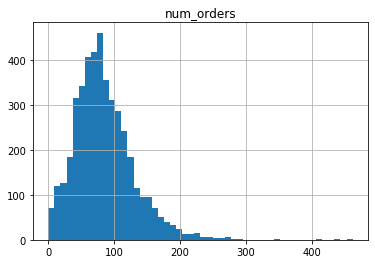

In [86]:
a = data_1hour.hist(bins=50)

In [87]:
data_1hour.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Гистограмма кол-ва заказов за час напоминает распределение Пуассона - вообще говоря, как и должно быть в теории. Тот факт, что средняя интенсивность заказов за имеющийся у нас отрезок времени возросла примерно вдвое, объясняет бОльшую дисперсию. Есть значительное кол-во выбросов, превосходящих средние в несколько раз (3-5).

## 2.2. Формирование обучающих признаков модели.

В данной работе предпринята попытка исследовать влияние всех изученных в тренажере рукотворных признаков для временного ряда на конечное качество модели. 
- Идея эксперимента простая - берем все возможные признаки (lag и rolling можно набирать почти бесконечно, сколько хватит данных, но я хотел дойти до того максимума, когда добавление перестанет увеличивать точность - и это получилось, как видно на следующем этапе моей работы). 
- Находим наилучший набор, используя приблизительный алгоритм (описан ниже). 
- Затем - важный шаг исследования - пытаемся сократить число обучающих признаков в лучшем наборе, используя feature_importances (для линейной регрессии был введен такой параметр на основе coef_). 
    
Для выбора необходимого набора параметров были следующие соображения:

1) Использование lag для линейной регрессией можно расценить как способ построить ряд Тейлора для прогнозирования аналитической функции. Я не делал строгих математических выводов, но логика следующая. Считаем сдвижку 1 час достаточно маленькой, так что можно считать dt = 1. Тогда lag2-lag1 ~ f', (где f - функция аппроксимирующая наш временной ряд).   И далее: (lag4-lag3) - (lag2-lag1) ~ f'' и ... То есть я "набрал" обучающих признаков примерно до 8ой производной по времени. Это с одной стороны. <br>

2) С другой стороны можно рассматривать периодический временной ряд, как функцию, которую можно хорошо аппроксимировать рядом Фурье. По идее использование только данных опредлеленной периодичности - об этом. Есть суточный цикл - нужны 24 часовые сдвиги. Есть недельный цикл - нужны 168 сдвиги, и так далее. <br>

3) Если справедлива логика 1), тогда все lag должны использоваться "плотно" без пропусков, с затуханием весов. Это действительно так для линейной регрессии - смотри результаты ниже. Если справедлива логика 2), тогда должны быть пики важности конкретных лагов, а промежуточные лаги можно удалить - это оказалось справедливым для алгоритмов на основе решающего дерева. <br>

In [88]:
# модель будет предсказывать кол-во заказов на следующий час, ресемплируем ряд
data_1hour = data.resample('1H').sum()

# выделим целевой признак и сформируем обучающие признаки, которые будут во всех наборах данных
target_col = 'num_orders'
common_features_cols_list = ['month', 'day', 'dayofweek']

data_1hour['month'] = data_1hour.index.month
data_1hour['day'] = data_1hour.index.day
data_1hour['dayofweek'] = data_1hour.index.dayofweek

In [89]:
# создадим функции добавления обучающих признаков:

# средних данных за предыдущий период определенной длительности
def add_rolling_mean(rolling_size):
    data_1hour[f'rolling_mean_{rolling_size}'] = data_1hour['num_orders'].rolling(rolling_size).mean().shift(1)

# данных за предыдущие периоды
def add_shift(shift_number):
    data_1hour[f'shift_{shift_number}'] = data_1hour['num_orders'].shift(shift_number)

In [90]:
# зададим границы изменений рукотворных признаков

# список периодов времени (в часах), по которым будет формироваться скользящее усреднение
ROLL_MEAN_LIST = [6, 12, 24, 36, 48, 72, 96, 120, 144, 168, 192, 216, 240]

# максимальный сдвиг (в часах)
MAX_SHIFT = 240

In [91]:
# теперь сформируем все признаки, которые будут использоваться в разных наборах обучающих признаков
for rolling_size in ROLL_MEAN_LIST:
    add_rolling_mean(rolling_size)
for shift_number in range(1, MAX_SHIFT + 1):
    add_shift(shift_number)

In [92]:
data_1hour.head(13)

,num_orders,month,day,dayofweek,rolling_mean_6,rolling_mean_12,rolling_mean_24,rolling_mean_36,rolling_mean_48,rolling_mean_72,...,shift_231,shift_232,shift_233,shift_234,shift_235,shift_236,shift_237,shift_238,shift_239,shift_240
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,65.833333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,47.166667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,1,3,35.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


С одной стороны, кажется очевидным, что чем больше мы закладываем предыдущих значений ряда в нашу функцию предсказания, тем точнее должен быть прогноз. С другой стороны, всегда есть ограничение объема данных и если заложить слишком много предыдущих данных временного ряда в обучающие признаки, можно переобучить модель и не добиться хорошего результата предсказаний. Эти теоретические рассуждения хочется проверить экспериментально. Для этого создадим словарь, содержащий дэйтасеты с разным набором обучающих признаков, сформированных на основе предыдущих значений ряда. 

In [93]:
# создадим функцию для получения набора данных с ограниченным наборов признаков из data_1hour, содержащего все признаки
# другой путь - создать, например, словарь, содержащий все возможные наборы данных, но этот путь требует очень много памяти
# data_features = {}
base_cols_list = [target_col] + common_features_cols_list

def get_data(shift_thresh, roll_mean_thresh):
    shift_cols_list = [f'shift_{i}' for i in range(1, shift_thresh + 1)]
    rolling_mean_cols_list = [f'rolling_mean_{i}' for i in ROLL_MEAN_LIST if i <= roll_mean_thresh]
    return data_1hour[base_cols_list + shift_cols_list + rolling_mean_cols_list]   

In [94]:
# для проверки посмотрим на один из элементов словаря
get_data(5, 36)

,num_orders,month,day,dayofweek,shift_1,shift_2,shift_3,shift_4,shift_5,rolling_mean_6,rolling_mean_12,rolling_mean_24,rolling_mean_36
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,172.666667,163.416667,164.875000,169.944444
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,167.666667,170.916667,167.541667,172.638889
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,171.166667,168.583333,168.041667,172.305556


In [95]:
# теперь создадим функции разделения наборов данных на обучающие, валидационные и тестовые выборки в соотношении 8:1:1
# деление на три выборки максимально приближает наш эксперимент к реальным условиям:
# мы делим все имеющиеся у нас исторические данные на обучающие и проверочные (~10%), 
# затем при помощи проверочных данных мы выбираем наилучший набор признаков+наилучшие гиперпараметры модели (train+valid),
# выбрав таким образом модель мы запускаем ее в продакшн и смотрим, как она ведет себя в реальных условиях (test)
# X_train = {}
# y_train = {}
# X_valid = {}
# y_valid = {}
# X_test = {}
# y_test = {}

def get_datasets(shift_thresh, roll_mean_thresh):
    data_features_cut = get_data(shift_thresh, roll_mean_thresh)
    train, valid = train_test_split(data_features_cut, shuffle=False, test_size=0.2)
    train = train.dropna()
    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    X_valid = valid.drop(columns=[target_col])
    y_valid = valid[target_col]
    X_valid, X_test, y_valid, y_test  = train_test_split(X_valid, y_valid, shuffle=False, test_size=0.5)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [96]:
# для проверки посмотрим на один из элементов всех словарей
X_train, X_valid, X_test, y_train, y_valid, y_test = get_datasets(10, 24)
display(X_train, X_valid, X_test, y_train, y_valid, y_test)

,month,day,dayofweek,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,rolling_mean_6,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,69.333333,56.583333,56.833333
2018-03-02 01:00:00,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,72.166667,61.583333,55.416667
2018-03-02 02:00:00,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,84.666667,68.916667,56.875000
2018-03-02 03:00:00,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,87.000000,71.166667,57.041667
2018-03-02 04:00:00,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,86.666667,71.000000,56.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-25 23:00:00,7,25,2,84.0,110.0,111.0,137.0,68.0,121.0,134.0,119.0,95.0,99.0,105.166667,104.500000,103.625000
2018-07-26 00:00:00,7,26,3,138.0,84.0,110.0,111.0,137.0,68.0,121.0,134.0,119.0,95.0,108.000000,108.250000,104.791667
2018-07-26 01:00:00,7,26,3,149.0,138.0,84.0,110.0,111.0,137.0,68.0,121.0,134.0,119.0,121.500000,113.750000,104.291667


,month,day,dayofweek,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,rolling_mean_6,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,,
2018-07-26 04:00:00,7,26,3,141.0,197.0,73.0,149.0,138.0,84.0,110.0,111.0,137.0,68.0,130.333333,121.916667,106.375000
2018-07-26 05:00:00,7,26,3,131.0,141.0,197.0,73.0,149.0,138.0,84.0,110.0,111.0,137.0,138.166667,121.666667,106.666667
2018-07-26 06:00:00,7,26,3,83.0,131.0,141.0,197.0,73.0,149.0,138.0,84.0,110.0,111.0,129.000000,118.500000,107.250000
2018-07-26 07:00:00,7,26,3,21.0,83.0,131.0,141.0,197.0,73.0,149.0,138.0,84.0,110.0,107.666667,114.583333,105.416667
2018-07-26 08:00:00,7,26,3,39.0,21.0,83.0,131.0,141.0,197.0,73.0,149.0,138.0,84.0,102.000000,106.416667,104.541667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,8,13,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,98.333333,158.166667,134.041667
2018-08-13 10:00:00,8,13,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,93.166667,158.333333,135.250000
2018-08-13 11:00:00,8,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,95.333333,161.500000,137.250000


,month,day,dayofweek,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,rolling_mean_6,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,8,13,0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,123.166667,139.583333,138.541667
2018-08-13 15:00:00,8,13,0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,125.000000,111.666667,138.458333
2018-08-13 16:00:00,8,13,0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,131.333333,112.250000,139.541667
2018-08-13 17:00:00,8,13,0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,129.333333,112.333333,139.166667
2018-08-13 18:00:00,8,13,0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,130.666667,118.083333,140.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,172.666667,163.416667,164.875000
2018-08-31 20:00:00,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,167.666667,170.916667,167.541667
2018-08-31 21:00:00,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,171.166667,168.583333,168.041667


datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
                      ... 
2018-07-25 23:00:00    138
2018-07-26 00:00:00    149
2018-07-26 01:00:00     73
2018-07-26 02:00:00    197
2018-07-26 03:00:00    141
Freq: H, Name: num_orders, Length: 3508, dtype: int64

datetime
2018-07-26 04:00:00    131
2018-07-26 05:00:00     83
2018-07-26 06:00:00     21
2018-07-26 07:00:00     39
2018-07-26 08:00:00     80
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 442, dtype: int64

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 442, dtype: int64

# 3. Обучение и тестирование.

## 3.1. Подготовка, реализация алгоритма поиска лучшего набора обучающих признаков

In [97]:
# для исследования моделей для разных наборов данных создадим несколько функций

# получение rmse на определенном наборе данных для обученной модели
def get_rmse(model, X, y):
    y_predict = model.predict(X)
    return mean_squared_error(y, y_predict) ** 0.5

# обучение модели на выборанном наборе обучающих признаков
def fit_and_validate(model, shift_number, rolling_size):
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_datasets(shift_number, rolling_size)
    model.fit(X_train, y_train)
    return model, get_rmse(model, X_valid, y_valid)

Количество наборов данных достаточно велико. Для поиска лучшего набора обучающих признаков можно, конечно, действовать в лоб - обучить модели на всех наборах данных и затем выбрать наилучшую модель. При больших наборах данных это слишком расточительный метод. 

Для исследования применим следующий простой приближенный алгоритм:
1. Представим себе таблицу, в каждой ячейке которой данные с определенным набором признаков, где  max_shifts - номер строки, а max_rolling_mean - номер столбца.
2. Обучаем все модели в n строке (при инициации n=1), находим минимум rmse on valid, допустим, это m столбец.
3. Обучаем все модели в m столбце, находим минимум rmse on valid, допустим, это n строка.
4. Возвращаемся к шагу 2

In [98]:
# список периодов времени (в часах), по которым будет формироваться скользящее усреднение
ROLL_MEAN_LIST = [6, 12, 24, 36, 48, 72, 96, 120, 144, 168, 192, 216, 240]

# максимальный сдвиг (в часах)
MAX_SHIFT = 240

In [99]:
# для реализации алгоритма создадим функцию, которая помимо поиска лучшего набора обучающих признаков 
# еще и визуализирует результаты проверки качества обученных моделей

def is_processed(iter_list, new_value): # вспомогательная функция для основной функции реализации алгоритма
    if len(iter_list) == 0:
        prev_value = 0
    else:
        prev_value = iter_list[-1]
    return new_value == prev_value


def get_best_model(n_iterations, model_method, shifts_step=1, **kw_model):
    start_time = time.time()
    models = {}
    rmses = pd.DataFrame()
    shift_number_better = 1
    n = 1
    rows = []
    cols = []
    for n in range(n_iterations + 1):
        if is_processed(rows, shift_number_better):
            break
        for rolling_size in ROLL_MEAN_LIST: # проход строки
            model = model_method(**kw_model)
            models[(shift_number_better, rolling_size)], rmse_on_valid = fit_and_validate(model, shift_number_better, rolling_size)
            rmses.loc[shift_number_better, rolling_size] = rmse_on_valid
        rows.append(shift_number_better)
        rolling_size_better = rmses.loc[shift_number_better,:].idxmin()
        if is_processed(cols, rolling_size_better):
            break
        for shift_number in range(1, MAX_SHIFT + 1, shifts_step): # проход столбца
            model = model_method(**kw_model)
            models[(shift_number, rolling_size_better)], rmse_on_valid = fit_and_validate(model, shift_number, rolling_size_better)
            rmses.loc[shift_number, rolling_size_better] = rmse_on_valid
        cols.append(rolling_size_better)
        shift_number_better = rmses.loc[:, rolling_size_better].idxmin()
    ax = rmses[cols].plot(figsize=(14,8), grid=True)
    ax = ax.set(ylabel='RMSE on validation dataset', xlabel='max number of shifts in data')
    plt.show()
    ax1 = rmses.T[rows].plot(figsize=(14,8), grid=True)
    ax1 = ax1.set(ylabel='RMSE on validation dataset', xlabel='max rolling mean in data')
    end_time = time.time()
    return models[shift_number_better, rolling_size_better], shift_number_better, rolling_size_better, end_time - start_time

In [100]:
# создадим dataframes для сохранения результатов лучших моделей и важности признаков в лучшей модели
results_all = pd.DataFrame()
feature_importances_all = pd.DataFrame(index=data_1hour.drop(columns=[target_col]).columns)

# и словарь для хранения моделей
models_best = {}


# для добавления всех результатов rmse для какой-то лучшей модели создадим несколько функций
def make_index_from_name(model_name, max_shifts, rolling_mean):
    return model_name + f', max_shifts {max_shifts}, max_rolling_mean {rolling_mean}'


def add_any_results(model_fitted, model_index, X_train, X_valid, X_test, y_train, y_valid, y_test, learning_time=None):
    models_best[model_index] = model_fitted
    if type(model_fitted).__name__ == 'LinearRegression':
        feature_importances_na = np.abs(model_fitted.coef_) * X_train.std()
    else:
        feature_importances_na = model_fitted.feature_importances_
    feature_importances_na = feature_importances_na / feature_importances_na.max() * 100
    feature_importances_series = pd.Series(feature_importances_na, index=X_train.columns)
    feature_importances_all.loc[:, model_index] = feature_importances_series
    results_all.loc[model_index, 'RMSE on test dataset'] = get_rmse(model_fitted, X_test, y_test)
    results_all.loc[model_index, 'RMSE on valid dataset'] = get_rmse(model_fitted, X_valid, y_valid)
    results_all.loc[model_index, 'RMSE on train dataset'] = get_rmse(model_fitted, X_train, y_train)
    results_all.loc[model_index, 'Number of features'] = len(X_train.columns)
    results_all.loc[model_index, 'Learning time'] = learning_time
    display(results_all)

def add_results(model_fitted, model_name, max_shifts, rolling_mean, learning_time):
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_datasets(max_shifts, rolling_mean)
    add_any_results(model_fitted, make_index_from_name(model_name, max_shifts, rolling_mean), X_train, X_valid, X_test, y_train, y_valid, y_test, learning_time)
    

## 3.2. Исследование линейной регрессии.

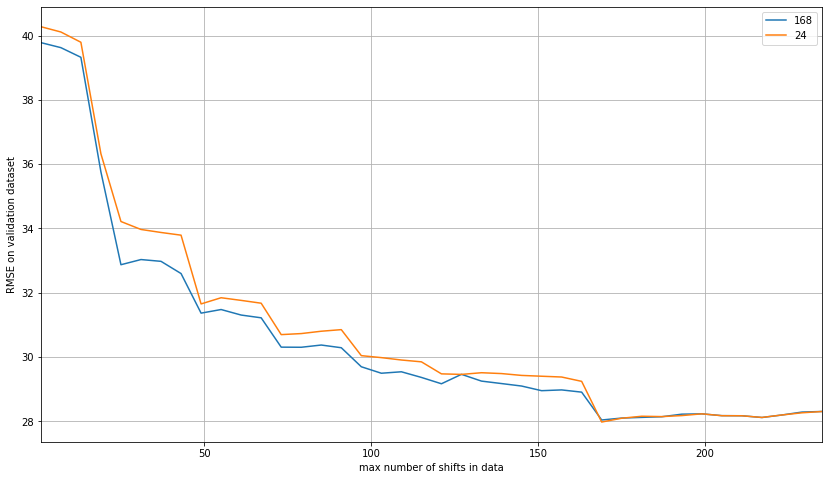

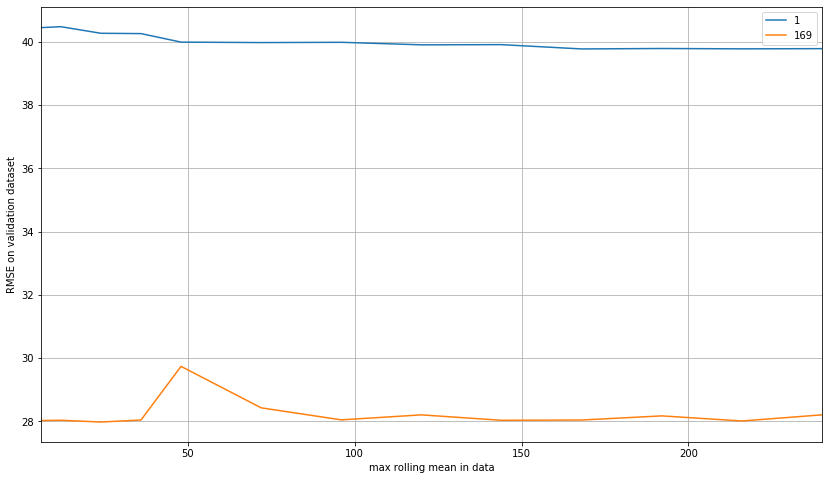

In [101]:
lin_regression_best, max_shifts_best, rolling_mean_best, learning_time = get_best_model(3, LinearRegression, shifts_step=6)

Для получения лучшего набора обучающих признаков для линейной регрессии оказалось достаточно двух итераций. Следует отметить, что использованный алгоритм выбора лучших параметров, конечно же, не гарантирует получения лучших параметров, даже если использовать шаг приращения=1 (мы для экономии времени всюду используем шаги в р-не 5). Мы можем попасть в локальный минимум, тем более, что графики демонстрируют не монотонное поведение оценок качества в зависимости от набора обучающих признаков. Тем не менее, имея в виду заданный критерий качества моделей, а именно: rmse < 48 на тестовом наборе, нам удалось достигнуть поставленной задачи пока на валидационном наборе с запасом.

In [102]:
add_results(lin_regression_best, 'линейная регрессия, параметры по умолчанию', max_shifts_best, rolling_mean_best, learning_time)

,RMSE on test dataset,RMSE on valid dataset,RMSE on train dataset,Number of features,Learning time
"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24",36.912594,27.976439,19.269822,175.0,43.689574


In [103]:
# лучшая в нашем исследовании модель линейной регрессии использует довольно много признаков, посмотрим на вклад каждого признака 
feature_importances_all

,"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24"
month,1.985363e-11
day,8.168767e-12
dayofweek,2.772638e-12
rolling_mean_6,1.000000e+02
rolling_mean_12,2.253017e+01
...,...
shift_236,NaN
shift_237,NaN
shift_238,NaN
shift_239,NaN


In [104]:
# у нас явно есть признаки, которые вносят очень небольшую поправку в конечный результат - например, поля month, day, dayofweek
# посмотрим на признаки, importance которых больше некоторой величины

# создадим для этого функцию, чтобы использовать такой просмотр и для других моделей
def view_important_features(model_index, threshold):
    filter = feature_importances_all.iloc[:, model_index] > threshold
    series_to_show = feature_importances_all[filter].iloc[:, model_index]
    title_str = f'Feature importance > {threshold}, ' + feature_importances_all.columns[model_index]
    series_to_show.plot(figsize=(16, 6), grid=True, kind='bar', title=title_str)
    display(series_to_show)

rolling_mean_6     100.000000
rolling_mean_12     22.530174
rolling_mean_24     16.375153
shift_1             30.165518
shift_2             30.114544
shift_3             30.123963
shift_4             30.108570
shift_5             30.094682
shift_6             30.096660
shift_7              5.008543
shift_8              5.008226
shift_9              5.006484
shift_10             5.006797
shift_11             5.006171
shift_12             5.004374
shift_13             1.508838
shift_14             1.508820
shift_15             1.509018
shift_16             1.509118
shift_17             1.509305
shift_18             1.509831
shift_19             1.509996
shift_20             1.510729
shift_21             1.510690
shift_22             1.510687
shift_23             1.511140
shift_24             1.511090
Name: линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24, dtype: float64

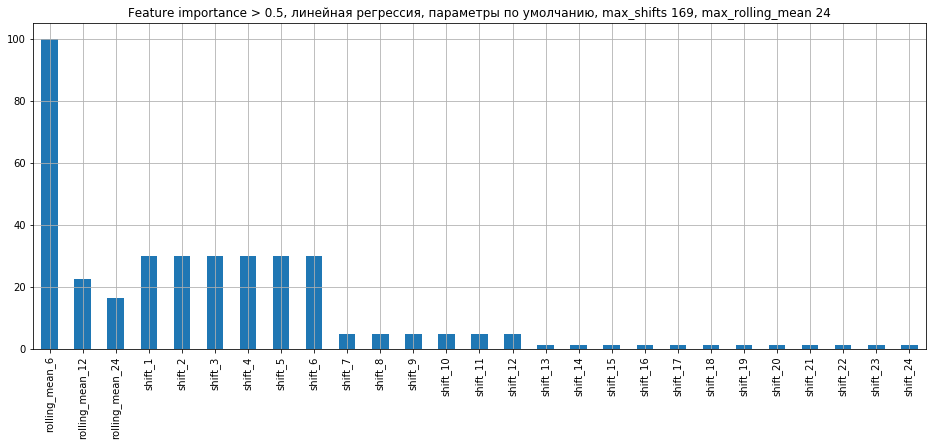

In [105]:
view_important_features(0, 0.5)

rolling_mean_6     100.000000
rolling_mean_12     22.530174
rolling_mean_24     16.375153
shift_1             30.165518
shift_2             30.114544
shift_3             30.123963
shift_4             30.108570
shift_5             30.094682
shift_6             30.096660
shift_7              5.008543
shift_8              5.008226
shift_9              5.006484
shift_10             5.006797
shift_11             5.006171
shift_12             5.004374
shift_13             1.508838
shift_14             1.508820
shift_15             1.509018
shift_16             1.509118
shift_17             1.509305
shift_18             1.509831
shift_19             1.509996
shift_20             1.510729
shift_21             1.510690
shift_22             1.510687
shift_23             1.511140
shift_24             1.511090
Name: линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24, dtype: float64

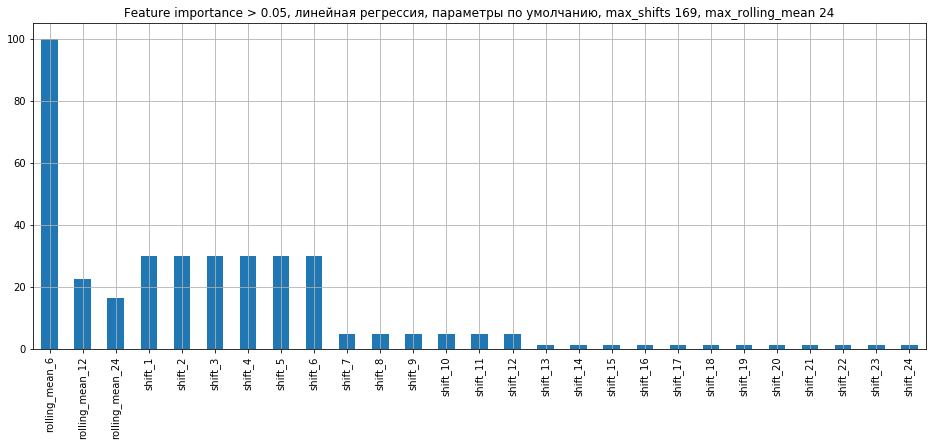

In [106]:
view_important_features(0, .05)

In [107]:
# создадим функцию для обучения и проверки качества модели при обучении на наборах данных только с важными признаками
def try_short_model(model_full_index, threshold, short_model_name, model_method, **kw_model):
    filter = feature_importances_all.iloc[:, model_full_index] >  threshold
    feat_list = feature_importances_all[filter].index.to_list() # get list of the most important features
    means = []
    shifts = []
    for feat in feat_list: # get 2 lists of 'shift_' and 'rolling_mean'
        if 'mean' in feat:
            means.append(feat)
        elif 'shift' in feat:
            shifts.append(feat)
    shift_thresh = max([int(item.replace('shift_','')) for item in shifts]) # get the maximum of shift_
    roll_mean_thresh = max([int(item.replace('rolling_mean_','')) for item in means]) # get the maximum of rolling_mean_
    X_train, X_valid, X_test, y_train_short, y_valid_short, y_test_short = get_datasets(shift_thresh, roll_mean_thresh)
    X_train_short = X_train[feat_list]  
    X_valid_short = X_valid[feat_list]
    X_test_short = X_test[feat_list]
    model = model_method(**kw_model)
    model.fit(X_train_short, y_train_short)
    model_full_name = short_model_name + f', нет признаков с feature_importance < {threshold}, max_shifts {shift_thresh}, max_rolling_mean {roll_mean_thresh}'
    add_any_results(model, model_full_name, X_train_short, X_valid_short, X_test_short, y_train_short, y_valid_short, y_test_short)

In [108]:
try_short_model(0, 0.5, 'линейная регрессия, параметры по умолчанию', LinearRegression)

,RMSE on test dataset,RMSE on valid dataset,RMSE on train dataset,Number of features,Learning time
"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24",36.912594,27.976439,19.269822,175.0,43.689574
"линейная регрессия, параметры по умолчанию, нет признаков с feature_importance < 0.5, max_shifts 24, max_rolling_mean 24",45.368397,34.231253,24.748271,27.0,NaN


## 3.3. Исследование случайного леса.

In [109]:
RANDOM_STATE_ALL = 134
N_ESTIMATORS_MIN = 10

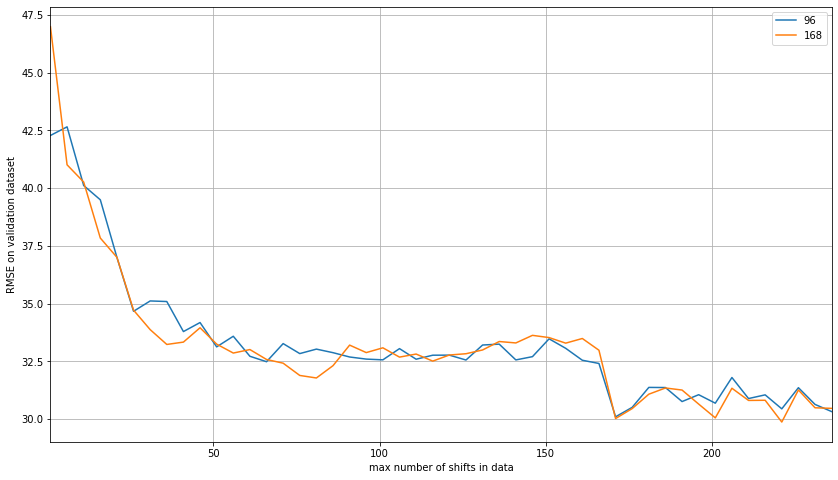

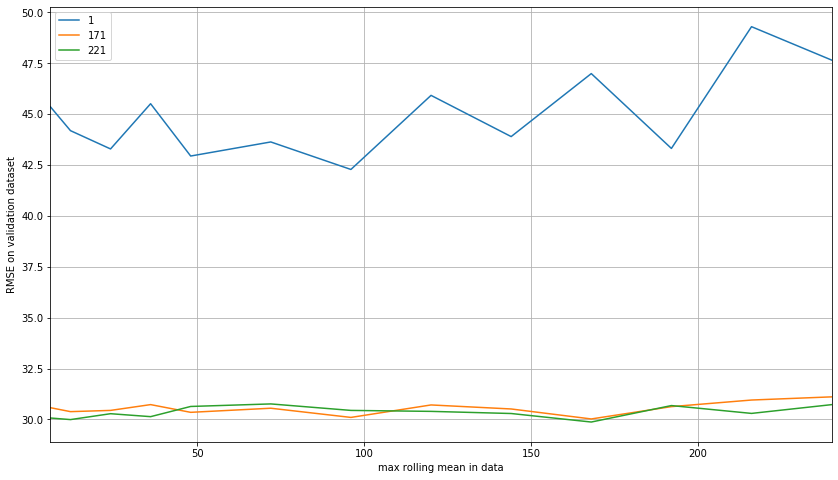

In [110]:
# сначала подберем наилучший набор обучающих признаков для модели с небольшим количеством оценщиков
model_rf_min_est, max_shifts_rf_min_est, rolling_mean_rf_min_est, learning_time = get_best_model(3, RandomForestRegressor, shifts_step=5, n_estimators=N_ESTIMATORS_MIN, random_state=RANDOM_STATE_ALL)

In [111]:
# теперь подберем оптимальное кол-во уровней случайного леса
def get_best_depth_rf(depth_min, depth_max, depth_step, max_shifts, rolling_mean):
    rmses_rf = pd.DataFrame()
    models_rf = {}
    for depth in range(depth_min, depth_max, depth_step):
        index_row = depth
        model = RandomForestRegressor(n_estimators=N_ESTIMATORS_MIN, random_state=RANDOM_STATE_ALL, max_depth=depth)
        models_rf[index_row], rmses_rf.loc[index_row, 'rmse on validation dataset'] = fit_and_validate(model, max_shifts, rolling_mean)
    index_of_best_model = rmses_rf['rmse on validation dataset'].idxmin()
    title_fig = f'Random forest, n_estimators={N_ESTIMATORS_MIN}, fitted with max_shifts {max_shifts}, max_rolling_mean {rolling_mean}. Best rmse with {index_of_best_model} max_depth.'
    ax = rmses_rf.plot(title=title_fig, figsize=(14,8), grid=True)
    ax = ax.set(ylabel='RMSE on validation dataset', xlabel=f'max_depth, start {depth_min}, end {depth_max}, step {depth_step}')
    return models_rf[index_of_best_model], index_of_best_model

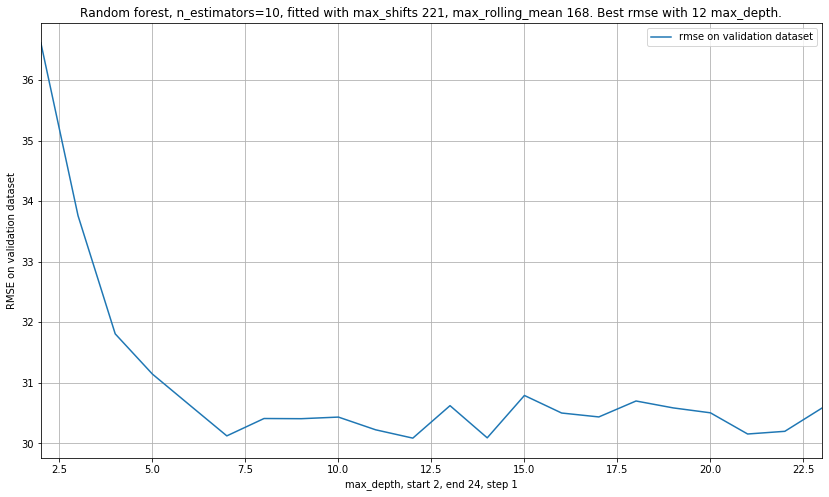

In [112]:
random_forest_best, max_depth_best = get_best_depth_rf(2, 24, 1, max_shifts_rf_min_est, rolling_mean_rf_min_est)

In [113]:
# наименьшая ошибка было при max_depth = 12, однако практически такая же ошибка была достигнута 
# и при ограничении в 7 уровней, из-за риска переобучения ограничимся глубиной 7
max_depth_best = 7

# теперь подберем наилучшее количество оценщиков случайного леса
def get_best_estimators_rf(n_est_min, n_est_max, n_est_step, max_shifts_rf, rolling_mean_rf):
    rmses_rf = pd.DataFrame()
    models_rf = {}
    for n_est in range(n_est_min, n_est_max, n_est_step):
        index_row = n_est
        model = RandomForestRegressor(n_estimators=n_est, random_state=RANDOM_STATE_ALL, max_depth=max_depth_best)
        models_rf[index_row], rmses_rf.loc[index_row, 'rmse on validation dataset'] = fit_and_validate(model, max_shifts_rf, rolling_mean_rf)
    index_of_best_model = rmses_rf['rmse on validation dataset'].idxmin()
    title_fig = f'Random forest,  max_depth={max_depth_best}, fitted with max_shifts {max_shifts_rf}, max_rolling_mean {rolling_mean_rf}. Best rmse with {index_of_best_model} n_estimators.'
    ax = rmses_rf.plot(title=title_fig, figsize=(14,8), grid=True)
    ax = ax.set(ylabel='RMSE on validation dataset', xlabel=f'number of estimators, start {n_est_min}, end {n_est_max}, step {n_est_step}')
    return models_rf[index_of_best_model], index_of_best_model

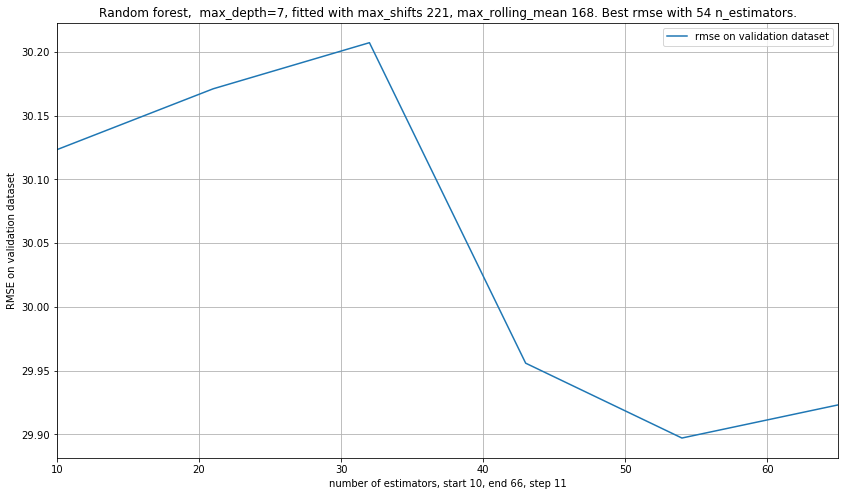

In [114]:
random_forest_best, n_estimators_best = get_best_estimators_rf(10, 66, 11, max_shifts_rf_min_est, rolling_mean_rf_min_est)

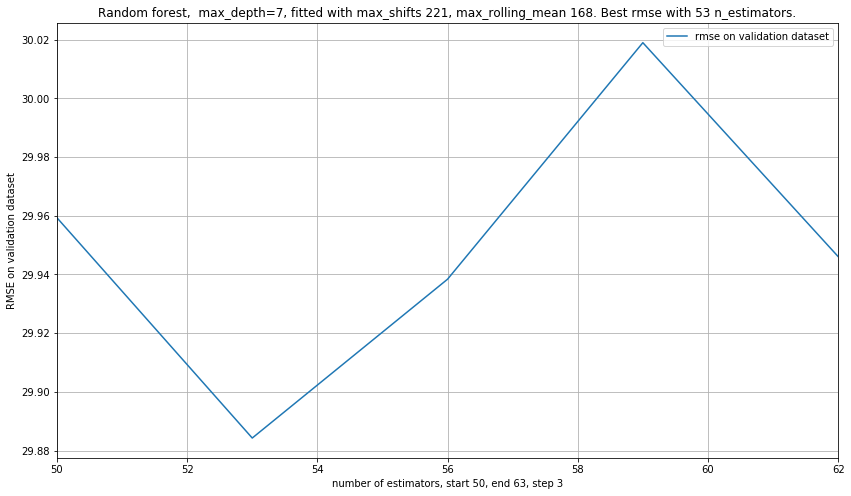

In [115]:
random_forest_best, n_estimators_best = get_best_estimators_rf(50, 63, 3, max_shifts_rf_min_est, rolling_mean_rf_min_est)

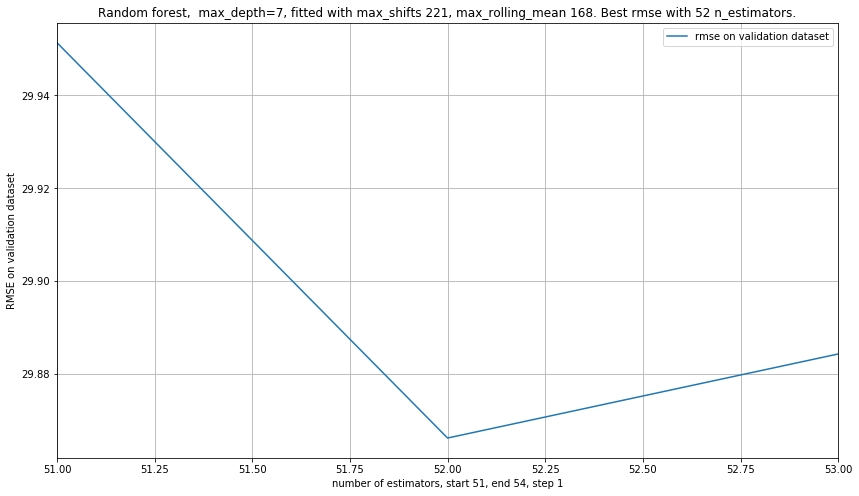

In [116]:
random_forest_best, n_estimators_best = get_best_estimators_rf(51, 54, 1, max_shifts_rf_min_est, rolling_mean_rf_min_est)

In [117]:
add_results(random_forest_best, f'случайный лес, лучшие n_estimators={n_estimators_best}, max_depth={max_depth_best}', max_shifts_rf_min_est, rolling_mean_rf_min_est, learning_time)

,RMSE on test dataset,RMSE on valid dataset,RMSE on train dataset,Number of features,Learning time
"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24",36.912594,27.976439,19.269822,175.0,43.689574
"линейная регрессия, параметры по умолчанию, нет признаков с feature_importance < 0.5, max_shifts 24, max_rolling_mean 24",45.368397,34.231253,24.748271,27.0,NaN
"случайный лес, лучшие n_estimators=52, max_depth=7, max_shifts 221, max_rolling_mean 168",43.797239,29.866153,15.217161,234.0,362.356827


rolling_mean_6       1.591525
rolling_mean_12      1.538483
shift_1              0.832963
shift_2              1.277454
shift_24             6.121878
shift_48             4.686111
shift_72             4.955284
shift_96             2.504537
shift_120            3.063054
shift_168          100.000000
shift_216            2.509546
Name: случайный лес, лучшие n_estimators=52, max_depth=7, max_shifts 221, max_rolling_mean 168, dtype: float64

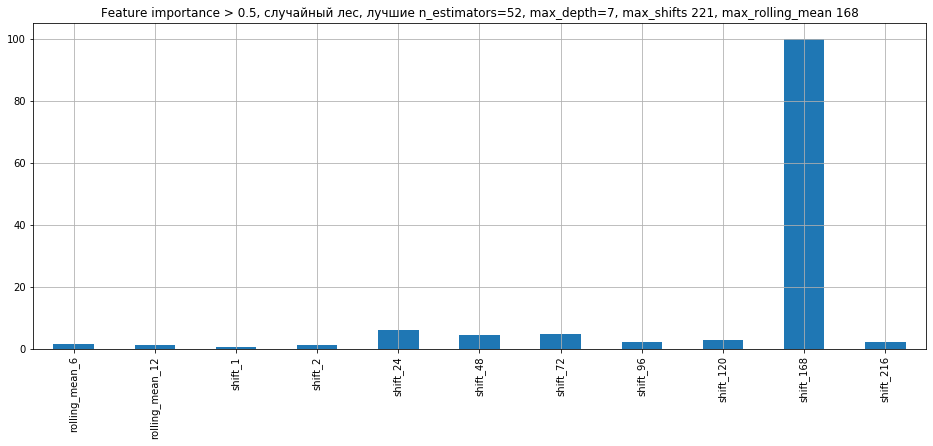

In [118]:
view_important_features(2, 0.5)

rolling_mean_6       1.591525
rolling_mean_12      1.538483
rolling_mean_24      0.206293
shift_1              0.832963
shift_2              1.277454
shift_6              0.206619
shift_7              0.440375
shift_18             0.265336
shift_23             0.310215
shift_24             6.121878
shift_32             0.299763
shift_40             0.230190
shift_47             0.201678
shift_48             4.686111
shift_49             0.319276
shift_72             4.955284
shift_78             0.203807
shift_90             0.219572
shift_96             2.504537
shift_120            3.063054
shift_128            0.308227
shift_138            0.347649
shift_154            0.207166
shift_162            0.213479
shift_163            0.368197
shift_167            0.228630
shift_168          100.000000
shift_169            0.238843
shift_186            0.216583
shift_192            0.252653
shift_199            0.213154
shift_206            0.205040
shift_214            0.306101
shift_215 

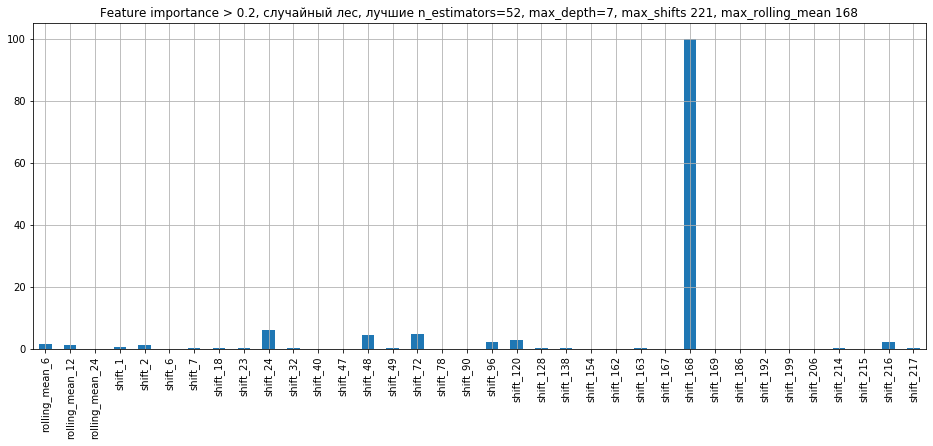

In [119]:
view_important_features(2, 0.2)

In [120]:
try_short_model(2, 0.2, f'случайный лес, n_estimators={n_estimators_best}, max_depth={max_depth_best}', RandomForestRegressor, n_estimators=n_estimators_best, random_state=RANDOM_STATE_ALL, max_depth=max_depth_best)

,RMSE on test dataset,RMSE on valid dataset,RMSE on train dataset,Number of features,Learning time
"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24",36.912594,27.976439,19.269822,175.0,43.689574
"линейная регрессия, параметры по умолчанию, нет признаков с feature_importance < 0.5, max_shifts 24, max_rolling_mean 24",45.368397,34.231253,24.748271,27.0,NaN
"случайный лес, лучшие n_estimators=52, max_depth=7, max_shifts 221, max_rolling_mean 168",43.797239,29.866153,15.217161,234.0,362.356827
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.2, max_shifts 217, max_rolling_mean 24",41.468010,29.181272,15.861742,36.0,NaN


day                0.135249
rolling_mean_6     1.591525
rolling_mean_12    1.538483
rolling_mean_24    0.206293
rolling_mean_36    0.142180
                     ...   
shift_215          0.210026
shift_216          2.509546
shift_217          0.275264
shift_218          0.185706
shift_219          0.184993
Name: случайный лес, лучшие n_estimators=52, max_depth=7, max_shifts 221, max_rolling_mean 168, Length: 112, dtype: float64

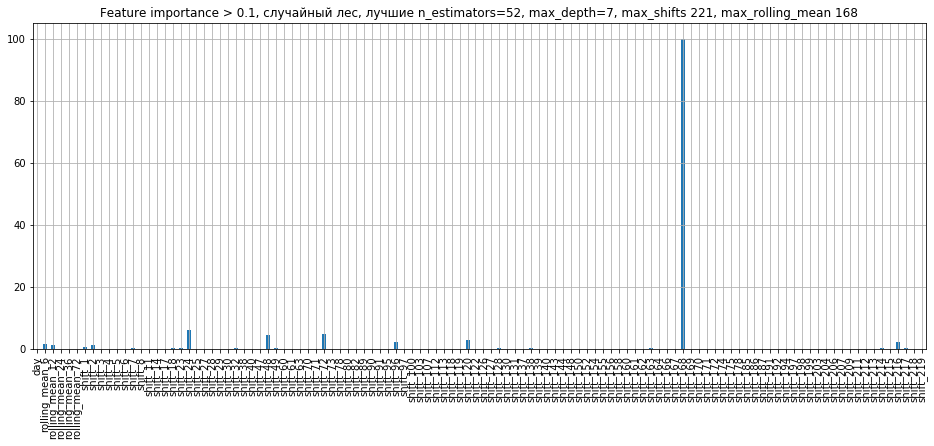

In [121]:
view_important_features(2, 0.1)

In [122]:
try_short_model(2, 0.1, f'случайный лес, n_estimators={n_estimators_best}, max_depth={max_depth_best}', RandomForestRegressor, n_estimators=n_estimators_best, random_state=RANDOM_STATE_ALL, max_depth=max_depth_best)

,RMSE on test dataset,RMSE on valid dataset,RMSE on train dataset,Number of features,Learning time
"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24",36.912594,27.976439,19.269822,175.0,43.689574
"линейная регрессия, параметры по умолчанию, нет признаков с feature_importance < 0.5, max_shifts 24, max_rolling_mean 24",45.368397,34.231253,24.748271,27.0,NaN
"случайный лес, лучшие n_estimators=52, max_depth=7, max_shifts 221, max_rolling_mean 168",43.797239,29.866153,15.217161,234.0,362.356827
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.2, max_shifts 217, max_rolling_mean 24",41.468010,29.181272,15.861742,36.0,NaN
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.1, max_shifts 219, max_rolling_mean 72",44.719930,30.188212,15.497091,112.0,NaN


Для случайного леса оказалось возможным существенно (примерно в 7 раз) сократить число обучающих признаков, при этом rmse на валидационном и тестовом наборах даже улучшилось

## 3.3. Исследование LightGBM.

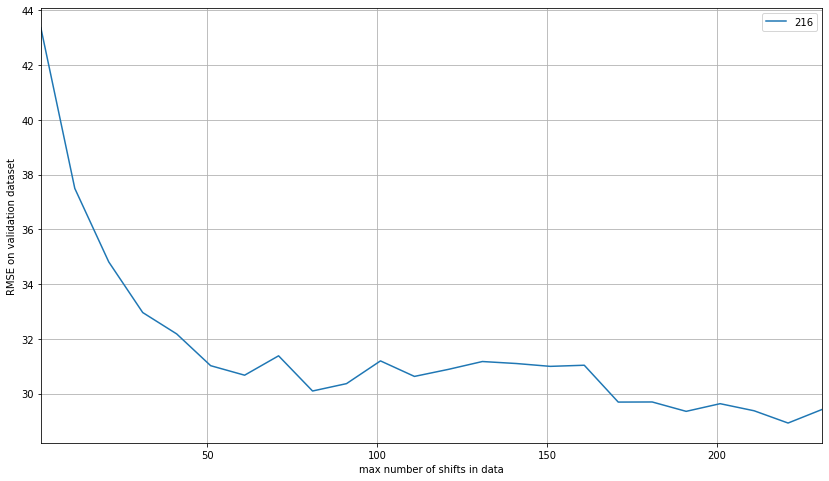

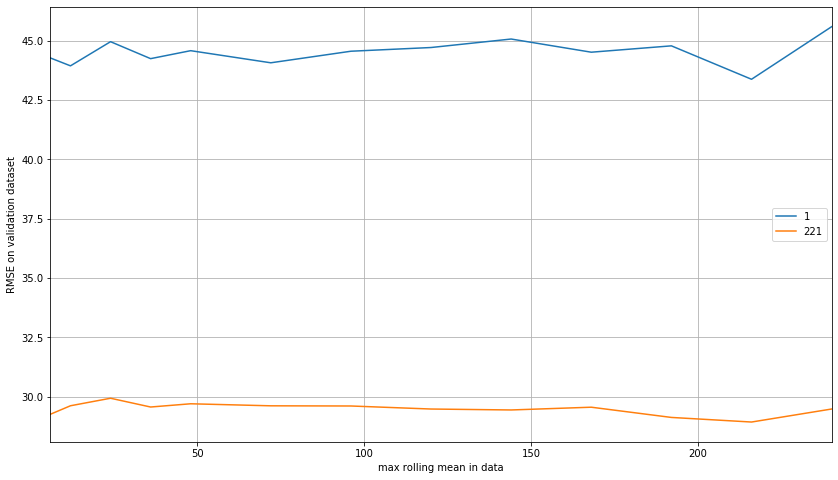

In [123]:
model_lgbm, max_shifts_lgbm, rolling_mean_lgbm, learning_time = get_best_model(3, lgb.LGBMRegressor, shifts_step=10, random_state=RANDOM_STATE_ALL)

In [124]:
max_shifts_lgbm, rolling_mean_lgbm

(221, 216)

In [125]:
# при выборе лучшего набора данных для LGBMRegressor использовались параметры по умолчанию, т.е. n_estimators=100,
# и без раннего прерырвания после проверки на валидационном наборе
# поэтому дополнительно обучим модель LGBMRegressor без указанных выше ограничений и посмотрим значение best_iteration_
model_lgbm_best = lgb.LGBMRegressor(random_state=RANDOM_STATE_ALL, n_estimators=5000)
X_train, X_valid, X_test, y_train, y_valid, y_test = get_datasets(max_shifts_lgbm, rolling_mean_lgbm)
model_lgbm_best.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)], 
            eval_metric='l2', 
            early_stopping_rounds=5,
            verbose=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=134, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [126]:
model_lgbm_best.best_iteration_

72

In [127]:
add_results(model_lgbm_best, f'градиентный бустинг LightGBM, параметры по умолчанию', max_shifts_lgbm, rolling_mean_lgbm, learning_time)

,RMSE on test dataset,RMSE on valid dataset,RMSE on train dataset,Number of features,Learning time
"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24",36.912594,27.976439,19.269822,175.0,43.689574
"линейная регрессия, параметры по умолчанию, нет признаков с feature_importance < 0.5, max_shifts 24, max_rolling_mean 24",45.368397,34.231253,24.748271,27.0,NaN
"случайный лес, лучшие n_estimators=52, max_depth=7, max_shifts 221, max_rolling_mean 168",43.797239,29.866153,15.217161,234.0,362.356827
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.2, max_shifts 217, max_rolling_mean 24",41.468010,29.181272,15.861742,36.0,NaN
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.1, max_shifts 219, max_rolling_mean 72",44.719930,30.188212,15.497091,112.0,NaN
"градиентный бустинг LightGBM, параметры по умолчанию, max_shifts 221, max_rolling_mean 216",43.838653,28.992077,9.156758,236.0,338.365271


day                26.470588
dayofweek          16.176471
rolling_mean_6     32.352941
rolling_mean_12    57.352941
rolling_mean_24    17.647059
                     ...    
shift_217          11.764706
shift_218          14.705882
shift_219          17.647059
shift_220          11.764706
shift_221           1.470588
Name: градиентный бустинг LightGBM, параметры по умолчанию, max_shifts 221, max_rolling_mean 216, Length: 235, dtype: float64

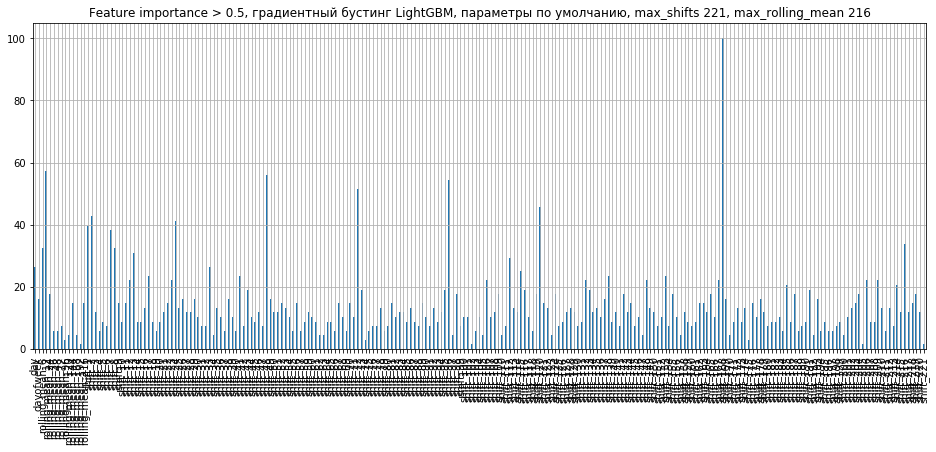

In [128]:
view_important_features(5, 0.5)

day                 26.470588
dayofweek           16.176471
rolling_mean_6      32.352941
rolling_mean_12     57.352941
rolling_mean_24     17.647059
shift_1             39.705882
shift_2             42.647059
shift_7             38.235294
shift_8             32.352941
shift_12            22.058824
shift_13            30.882353
shift_17            23.529412
shift_23            22.058824
shift_24            41.176471
shift_26            16.176471
shift_29            16.176471
shift_33            26.470588
shift_38            16.176471
shift_41            23.529412
shift_43            19.117647
shift_48            55.882353
shift_49            16.176471
shift_72            51.470588
shift_73            19.117647
shift_95            19.117647
shift_96            54.411765
shift_98            17.647059
shift_106           22.058824
shift_109           17.647059
shift_112           29.411765
shift_115           25.000000
shift_116           19.117647
shift_119           17.647059
shift_120 

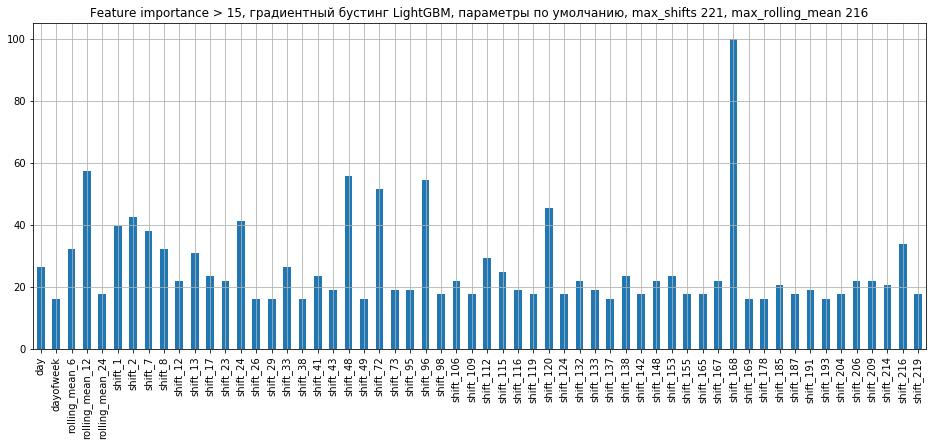

In [129]:
# уровень в 0.5 практически не уменьшил кол-во обучающих признаков, увеличим порог
view_important_features(5, 15)

In [130]:
try_short_model(5, 15, 'градиентный бустинг LightGBM, параметры по умолчанию', lgb.LGBMRegressor, random_state=RANDOM_STATE_ALL)

,RMSE on test dataset,RMSE on valid dataset,RMSE on train dataset,Number of features,Learning time
"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24",36.912594,27.976439,19.269822,175.0,43.689574
"линейная регрессия, параметры по умолчанию, нет признаков с feature_importance < 0.5, max_shifts 24, max_rolling_mean 24",45.368397,34.231253,24.748271,27.0,NaN
"случайный лес, лучшие n_estimators=52, max_depth=7, max_shifts 221, max_rolling_mean 168",43.797239,29.866153,15.217161,234.0,362.356827
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.2, max_shifts 217, max_rolling_mean 24",41.468010,29.181272,15.861742,36.0,NaN
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.1, max_shifts 219, max_rolling_mean 72",44.719930,30.188212,15.497091,112.0,NaN
"градиентный бустинг LightGBM, параметры по умолчанию, max_shifts 221, max_rolling_mean 216",43.838653,28.992077,9.156758,236.0,338.365271
"градиентный бустинг LightGBM, параметры по умолчанию, нет признаков с feature_importance < 15, max_shifts 219, max_rolling_mean 24",42.751904,29.315987,8.483654,58.0,NaN


In [131]:
try_short_model(5, 20, 'градиентный бустинг LightGBM, параметры по умолчанию', lgb.LGBMRegressor, random_state=RANDOM_STATE_ALL)

,RMSE on test dataset,RMSE on valid dataset,RMSE on train dataset,Number of features,Learning time
"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24",36.912594,27.976439,19.269822,175.0,43.689574
"линейная регрессия, параметры по умолчанию, нет признаков с feature_importance < 0.5, max_shifts 24, max_rolling_mean 24",45.368397,34.231253,24.748271,27.0,NaN
"случайный лес, лучшие n_estimators=52, max_depth=7, max_shifts 221, max_rolling_mean 168",43.797239,29.866153,15.217161,234.0,362.356827
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.2, max_shifts 217, max_rolling_mean 24",41.468010,29.181272,15.861742,36.0,NaN
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.1, max_shifts 219, max_rolling_mean 72",44.719930,30.188212,15.497091,112.0,NaN
"градиентный бустинг LightGBM, параметры по умолчанию, max_shifts 221, max_rolling_mean 216",43.838653,28.992077,9.156758,236.0,338.365271
"градиентный бустинг LightGBM, параметры по умолчанию, нет признаков с feature_importance < 15, max_shifts 219, max_rolling_mean 24",42.751904,29.315987,8.483654,58.0,NaN
"градиентный бустинг LightGBM, параметры по умолчанию, нет признаков с feature_importance < 20, max_shifts 216, max_rolling_mean 12",42.423020,29.194167,9.672020,32.0,NaN


# 4. Выводы.

In [132]:
results_all.sort_values(by='RMSE on test dataset')

,RMSE on test dataset,RMSE on valid dataset,RMSE on train dataset,Number of features,Learning time
"линейная регрессия, параметры по умолчанию, max_shifts 169, max_rolling_mean 24",36.912594,27.976439,19.269822,175.0,43.689574
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.2, max_shifts 217, max_rolling_mean 24",41.468010,29.181272,15.861742,36.0,NaN
"градиентный бустинг LightGBM, параметры по умолчанию, нет признаков с feature_importance < 20, max_shifts 216, max_rolling_mean 12",42.423020,29.194167,9.672020,32.0,NaN
"градиентный бустинг LightGBM, параметры по умолчанию, нет признаков с feature_importance < 15, max_shifts 219, max_rolling_mean 24",42.751904,29.315987,8.483654,58.0,NaN
"случайный лес, лучшие n_estimators=52, max_depth=7, max_shifts 221, max_rolling_mean 168",43.797239,29.866153,15.217161,234.0,362.356827
"градиентный бустинг LightGBM, параметры по умолчанию, max_shifts 221, max_rolling_mean 216",43.838653,28.992077,9.156758,236.0,338.365271
"случайный лес, n_estimators=52, max_depth=7, нет признаков с feature_importance < 0.1, max_shifts 219, max_rolling_mean 72",44.719930,30.188212,15.497091,112.0,NaN
"линейная регрессия, параметры по умолчанию, нет признаков с feature_importance < 0.5, max_shifts 24, max_rolling_mean 24",45.368397,34.231253,24.748271,27.0,NaN


- Были исследованы различные модели линейной регрессии, случайного леса и градиентного бустинга LightGBM на разных наборах обучающих признаков. Сводные результаты тестирования различных моделей представлены в таблице.
- Как видно из таблицы объявленному требованию по качеству rmse на тестовом наборе удовлетворяют все модели.
- Наилучшего результата добилась модель линейной регрессии. Кроме наименьшего rmse на тестовом наборе и наименьшего времени на поиск оптимального набора обучающих признаков, она продемонстрировала наименьшую разницу rmse на обучающих и проверочных данных, что свидетельствует о более низком риске переобученности. Кстати, это подтверждается результатами rmse на тестовом наборе - если на валидационном наборе разница между моделями не очень заметна, то на тестовом результаты существенно отличаются. Попытка сократить количество обучающих признаков для линейной регрессии, исходя из feature_importances, привела к существенному снижению качества модели. Имея в виду принцип составления различных наборов обучающих признаков - а именно, последовательное добавление все более ранних исторических данных - этот факт, как я считаю, свидетельствует о том, что метод линейной регрессии более полно использует всю последовательность исторических данных.
- Методы градиентного бустинга и случайного леса продемонстрировали примерно одинаковые результаты, которые заметно хуже линейной регрессии. Следует отметить, что лучшие модели этих алгоритмов были получены путем существенного сокращения количества обучающих признаков, исходя из feature_importances. При этом однако сокращение числа признаков не означает сокращения "глубины" требуемых для прогноза исторических данных - после сокращения неважных признаков требуемая "глубина" для этих алгоритмов составила примерно 216-217 часов, т.е. 9 дней, а для линейной регрессии максимальная "глубина" для лучшей модели - "всего" 169 часов или 7 дней. Существенная разница rmse на обучающем и проверочных наборах данных для всех моделей градиентного бустинга и случайного леса cвидетельствует о том, что, возможно, качество этих моделей можно было бы еще улучшить, поработав более тщательно с гиперпараметрами. В силу ограниченности вычислительных ресурсов эта работа не была закончена.
- Вычислительное время, потраченное на поиск оптимального набора обучающих признаков для линейной регрессии, значительно, почти на порядок, меньше, чем для градиентного бустинга и случайного леса.